## Objetivo de la competición

Somos un banco digital que lleva unos pocos meses operando en distintos países de Europa. Estamos pensando sacar un producto novedoso, una nueva tarjeta de crédito con muchas ventajas para distintos tipos de clientes. Antes de nada, queremos entender qué tipo de usuario encajaría mejor con este producto. Conocemos a los clientes que adquirieron una tarjeta parecida en el pasado, y algunos de ellos dejaron de usarla. Necesitamos vuestra ayuda para entender qué tipo de clientes dejaron de usar la tarjeta, e identificar quién lo va a hacer en el futuro.

En resumen, queremos analizar las diferencias entre clientes fugados y activos y entrenar un sistema que sea capaz de predecir si un cliente se ha fugado.

## Formato de la competición

Los datos están disponibles en la pestaña Data, junto con una descripción de los ficheros y campos. El objetivo final es subir un fichero que contenga la resolución del problema, con las predicciones para cada uno de los clientes del fichero test.csv. Para ello, los participantes tienen varias opciones:

- Descargar los datos y trabajar localmente, con el lenguaje de programación y librerías que se considere apropiado.
- Trabajar con un notebook de Kaggle. En el apartado Code, los participantes pueden trabajar con notebooks de Jupyter, que tienen preinstalados muchos de las librerías de Python más comunes. Si se opta por esta modalidad, hay un ejemplo de notebook (example_notebook.ipynb) que muestra como cargar los datos, y un esqueleto con pasos a seguir.

Al entregar una solución, se hará pública el resultado sobre una parte del conjunto de test en el apartado Leaderboard. Los participantes podrán ver su posición en tiempo real. Sin embargo, hay una clasificación privada, que se calcula con la parte restante del conjunto de test, que se hará pública al final del evento, y será la que se use para elegir al ganador. La razón detrás de esto es evitar posibles sobre-ajustes sobre este conjunto de datos.

https://www.kaggle.com/competitions/2211-credit-card-churn-immune-online/overview


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from math import sqrt
import xgboost as xgb                     
from xgboost.sklearn import XGBClassifier 
from xgboost.sklearn import XGBRegressor  
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = 12, 8
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
# df = train
# df2 = test 

df = pd.read_csv("train.csv")
df.drop("customer_id", axis=1, inplace=True)

df2 = pd.read_csv("test.csv")
df2.drop("customer_id", axis=1, inplace=True)


df

,customer_age,education_level,marital_status,income_category,number_products_customer,weeks_tenure,contacts_last_12mths,credit_limit,card_class,inactive_months_last_12mths,total_revolving_balance,count_transactions,transactions_amount,change_transaction_amt_last_3mths,change_transaction_count_last_3mths,churn
0,NaN,phd,NaN,30k€-50k€,4,216,1,16541.0,red plus,2,1428,82,4352,0.846,0.907,0
1,45.0,graduate,single,<30k€,5,115,3,1438.3,red,3,576,66,5098,0.774,0.833,0
2,NaN,uneducated,married,30k€-50k€,6,172,2,2293.0,red,1,1460,74,4436,0.658,0.542,0
3,39.0,graduate,married,70k€-110k€,5,124,2,17523.0,red,2,0,54,1974,0.424,0.688,1
4,40.0,graduate,single,<30k€,2,107,2,4391.0,red,2,1933,36,1849,0.579,0.385,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4387,27.0,high school,single,NaN,5,147,3,3184.0,red,2,1421,59,2253,0.712,0.439,0
4388,50.0,NaN,married,<30k€,3,175,0,5139.0,red,3,0,44,1653,0.330,0.692,1
4389,48.0,uneducated,single,<30k€,3,180,2,2094.0,red,3,0,46,2690,0.897,0.484,1
4390,NaN,graduate,divorced,30k€-50k€,1,116,3,5821.0,red,2,894,42,2011,0.461,0.273,1


Here we can see that we have many columns with missing data. In a preliminary analysis I just foward fill each one of those and achieved an excelent result. This time I will fill the missing values with the most common value for that class. For example:

If the most common salary for a phd is 30k-50K, I will fill every missing education_level with that salary with phd, and vice-versa. Let's see what happens 


In [3]:
#Let's check what's missing 

df.isnull().sum()

customer_age                           429
education_level                        657
marital_status                         318
income_category                        501
number_products_customer                 0
weeks_tenure                             0
contacts_last_12mths                     0
credit_limit                             0
card_class                               0
inactive_months_last_12mths              0
total_revolving_balance                  0
count_transactions                       0
transactions_amount                      0
change_transaction_amt_last_3mths        0
change_transaction_count_last_3mths      0
churn                                    0
dtype: int64

In [4]:
df2.isnull().sum()

customer_age                           195
education_level                        279
marital_status                         142
income_category                        202
number_products_customer                 0
weeks_tenure                             0
contacts_last_12mths                     0
credit_limit                             0
card_class                               0
inactive_months_last_12mths              0
total_revolving_balance                  0
count_transactions                       0
transactions_amount                      0
change_transaction_amt_last_3mths        0
change_transaction_count_last_3mths      0
dtype: int64

In [5]:
#First I will fill the age with the mean 

df['customer_age'] = df['customer_age'].fillna(value=df["customer_age"].mean())

df2['customer_age'] = df2['customer_age'].fillna(value=df2["customer_age"].mean())



In [6]:
# Counting the most common income for each class 

count_class = df.groupby(["education_level"])['income_category'].value_counts()


count_class


education_level  income_category
college          <30k€              152
                 70k€-110k€          80
                 30k€-50k€           78
                 50k€-70k€           56
                 +110k€              27
graduate         <30k€              493
                 30k€-50k€          247
                 70k€-110k€         194
                 50k€-70k€          174
                 +110k€              93
high school      <30k€              288
                 70k€-110k€         145
                 30k€-50k€          138
                 50k€-70k€          133
                 +110k€              55
phd              <30k€               67
                 30k€-50k€           30
                 70k€-110k€          30
                 50k€-70k€           26
                 +110k€              14
post-graduate    <30k€               81
                 30k€-50k€           44
                 70k€-110k€          40
                 50k€-70k€           37
       

<AxesSubplot:xlabel='income_category', ylabel='count'>

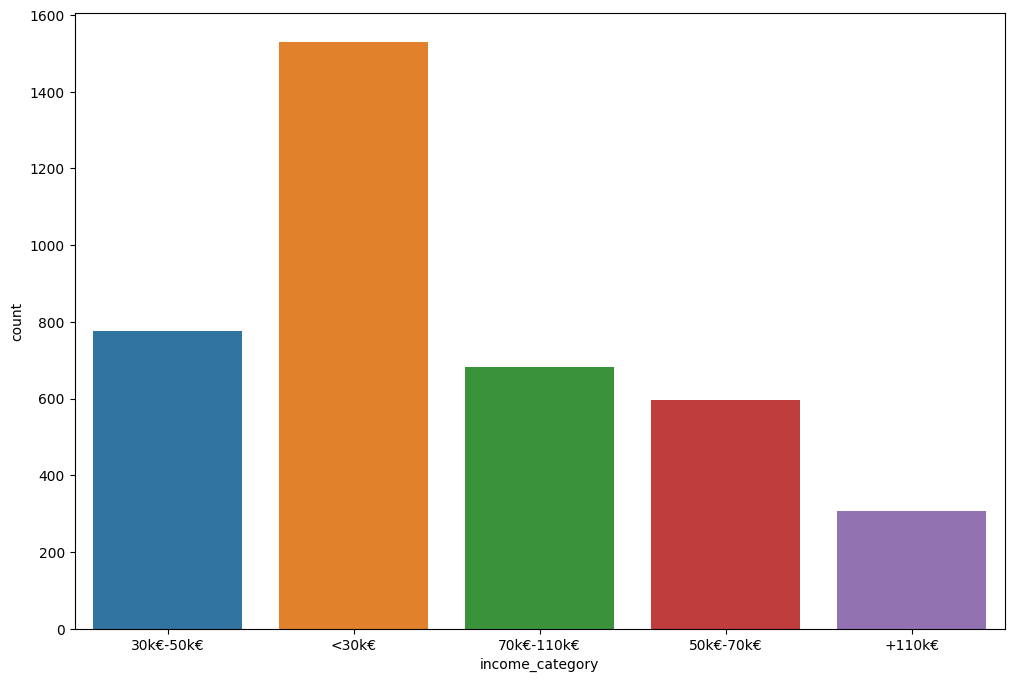

In [7]:
sns.countplot(x='income_category', data=df)

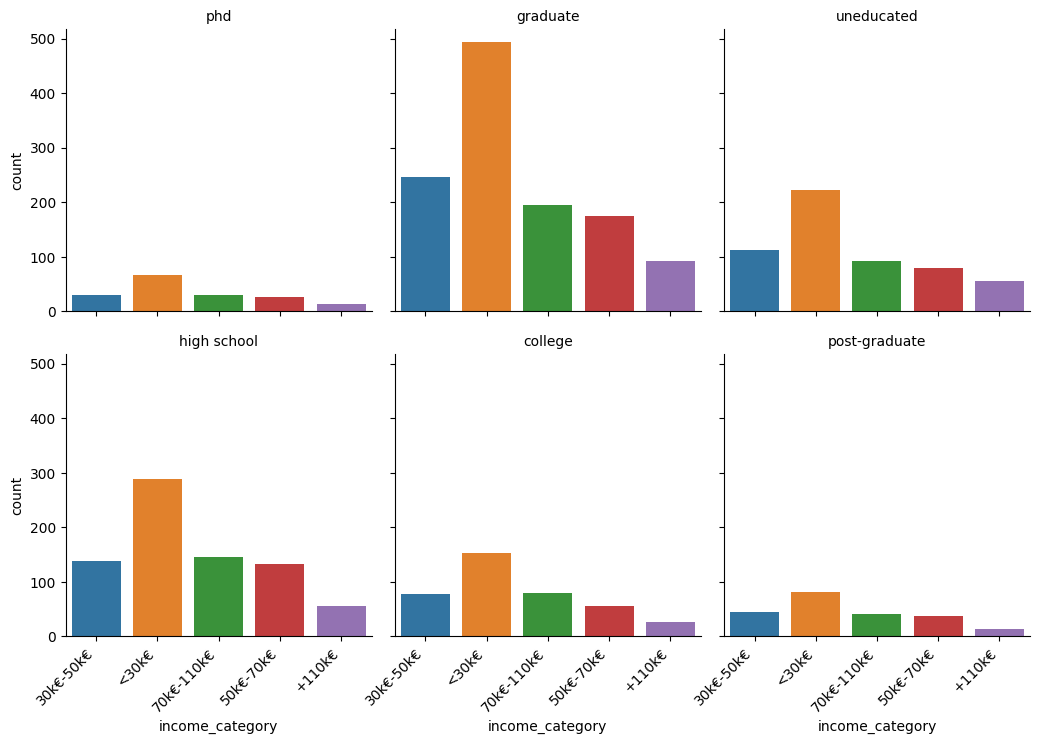

In [8]:


ax = sns.catplot(kind='count', data=df, col='education_level', col_wrap=3, x='income_category', height=3.5)
ax.set_titles(row_template='{row_name}', col_template='{col_name}')  

ax.set_xticklabels(rotation=45, ha="right")


plt.show()

I was expecting that different education level would have different income categories. We can randomly fill those values with foward fill, or with the mode. I did with random values and had a good result, but now I will do it will the mode. 

In [9]:
# get the mode for education_level 

df.education_level.value_counts()

graduate         1353
high school       872
uneducated        632
college           439
post-graduate     232
phd               207
Name: education_level, dtype: int64

In [10]:
#get the mode for marital_status 

df.marital_status.value_counts()

married     2023
single      1724
divorced     327
Name: marital_status, dtype: int64

In [11]:
#Lets fill the NaN for train and test dataset with the mode
df['education_level'] = df['education_level'].fillna(value="graduate")

df['marital_status'] = df['marital_status'].fillna(value="married")

df['income_category'] = df['income_category'].fillna(value="<30k€")

#df2

df2['education_level'] = df2['education_level'].fillna(value="graduate")

df2['marital_status'] = df2['marital_status'].fillna(value="married")

df2['income_category'] = df2['income_category'].fillna(value="<30k€")

In [12]:
df.isnull().sum()

customer_age                           0
education_level                        0
marital_status                         0
income_category                        0
number_products_customer               0
weeks_tenure                           0
contacts_last_12mths                   0
credit_limit                           0
card_class                             0
inactive_months_last_12mths            0
total_revolving_balance                0
count_transactions                     0
transactions_amount                    0
change_transaction_amt_last_3mths      0
change_transaction_count_last_3mths    0
churn                                  0
dtype: int64

In [13]:
df

,customer_age,education_level,marital_status,income_category,number_products_customer,weeks_tenure,contacts_last_12mths,credit_limit,card_class,inactive_months_last_12mths,total_revolving_balance,count_transactions,transactions_amount,change_transaction_amt_last_3mths,change_transaction_count_last_3mths,churn
0,45.772647,phd,married,30k€-50k€,4,216,1,16541.0,red plus,2,1428,82,4352,0.846,0.907,0
1,45.000000,graduate,single,<30k€,5,115,3,1438.3,red,3,576,66,5098,0.774,0.833,0
2,45.772647,uneducated,married,30k€-50k€,6,172,2,2293.0,red,1,1460,74,4436,0.658,0.542,0
3,39.000000,graduate,married,70k€-110k€,5,124,2,17523.0,red,2,0,54,1974,0.424,0.688,1
4,40.000000,graduate,single,<30k€,2,107,2,4391.0,red,2,1933,36,1849,0.579,0.385,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4387,27.000000,high school,single,<30k€,5,147,3,3184.0,red,2,1421,59,2253,0.712,0.439,0
4388,50.000000,graduate,married,<30k€,3,175,0,5139.0,red,3,0,44,1653,0.330,0.692,1
4389,48.000000,uneducated,single,<30k€,3,180,2,2094.0,red,3,0,46,2690,0.897,0.484,1
4390,45.772647,graduate,divorced,30k€-50k€,1,116,3,5821.0,red,2,894,42,2011,0.461,0.273,1


In [14]:
df.income_category.unique()

array(['30k€-50k€', '<30k€', '70k€-110k€', '50k€-70k€', '+110k€'],
      dtype=object)

In [15]:
df.card_class.unique()

array(['red plus', 'red', 'red unlimited', 'premium'], dtype=object)

In [16]:
df.marital_status.unique()

array(['married', 'single', 'divorced'], dtype=object)

In [17]:
#Converting categorical to numerical, in this case I will add an hierarchy to the categories mannualy 

df["education_level"] = np.where(df.education_level == 'high school', 0,
                            np.where(df.education_level == 'college', 1,
                            np.where(df.education_level == 'graduate', 2,
                            np.where(df.education_level == 'post-graduate', 3,
                            np.where(df.education_level == 'phd', 4, 5)))))

df["income_category"] = np.where(df.income_category == '<30k€', 0,
                            np.where(df.income_category == '30k€-50k€', 1,
                            np.where(df.income_category == '50k€-70k€', 2,
                            np.where(df.income_category == '70k€-110k€', 3,
                            np.where(df.income_category == '+110k€', 4, 5)))))

df["marital_status"] = np.where(df.marital_status == 'single', 0,
                            np.where(df.marital_status == 'married', 1,
                            np.where(df.marital_status == 'divorced', 2, 3)))

df["card_class"] = np.where(df.card_class == 'red', 0,
                            np.where(df.card_class == 'red plus', 1,
                            np.where(df.card_class == 'red unlimited', 2, 
                            np.where(df.card_class == 'premium', 3, 4))))

In [18]:
#Converting categorical to numerical, in this case I will add an hierarchy to the categories mannualy 

df2["education_level"] = np.where(df2.education_level == 'high school', 0,
                            np.where(df2.education_level == 'college', 1,
                            np.where(df2.education_level == 'graduate', 2,
                            np.where(df2.education_level == 'post-graduate', 3,
                            np.where(df2.education_level == 'phd', 4, 5)))))

df2["income_category"] = np.where(df2.income_category == '<30k€', 0,
                            np.where(df2.income_category == '30k€-50k€', 1,
                            np.where(df2.income_category == '50k€-70k€', 2,
                            np.where(df2.income_category == '70k€-110k€', 3,
                            np.where(df2.income_category == '+110k€', 4, 5)))))

df2["marital_status"] = np.where(df2.marital_status == 'single', 0,
                            np.where(df2.marital_status == 'married', 1,
                            np.where(df2.marital_status == 'divorced', 2, 3)))

df2["card_class"] = np.where(df2.card_class == 'red', 0,
                            np.where(df2.card_class == 'red plus', 1,
                            np.where(df2.card_class == 'red unlimited', 2, 
                            np.where(df2.card_class == 'premium', 3, 4))))

In [19]:
df.dtypes

customer_age                           float64
education_level                          int64
marital_status                           int64
income_category                          int64
number_products_customer                 int64
weeks_tenure                             int64
contacts_last_12mths                     int64
credit_limit                           float64
card_class                               int64
inactive_months_last_12mths              int64
total_revolving_balance                  int64
count_transactions                       int64
transactions_amount                      int64
change_transaction_amt_last_3mths      float64
change_transaction_count_last_3mths    float64
churn                                    int64
dtype: object

In [20]:
#Class distribution

print("Class distribution: "+ str(round(df["churn"].describe()[1]*100,2))+"%")

Class distribution: 26.05%


In [21]:
# Statistics for the clients that are still with the bank (0) and not not with the bank (1)

df[df["churn"] == 0]["transactions_amount"].describe()

count     3248.000000
mean      4613.610530
std       3485.560352
min        816.000000
25%       2311.000000
50%       4098.500000
75%       4780.000000
max      18484.000000
Name: transactions_amount, dtype: float64

In [22]:
df[df["churn"] == 1]["transactions_amount"].describe()

count     1144.000000
mean      3068.202797
std       2296.001788
min        510.000000
25%       1873.500000
50%       2315.500000
75%       2753.250000
max      10583.000000
Name: transactions_amount, dtype: float64

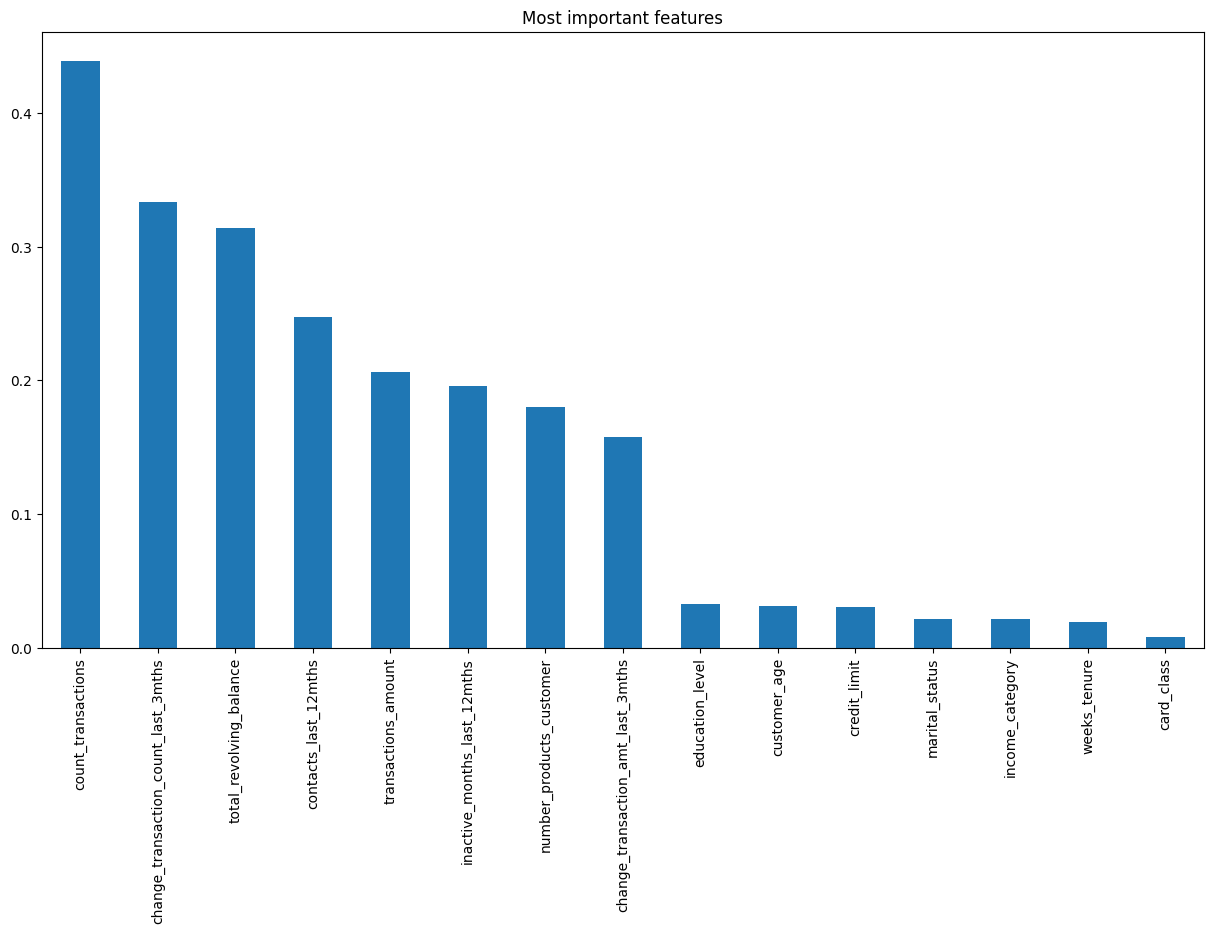

In [23]:
#Let's check the correlation between variables and Fraud 

plt.figure(figsize=(15,8))
d = df.corr()['churn'][:-1].abs().sort_values(ascending=False).plot(kind='bar', title='Most important features')

plt.show()

As expected the categorical variables are not relevant to the churn rate 

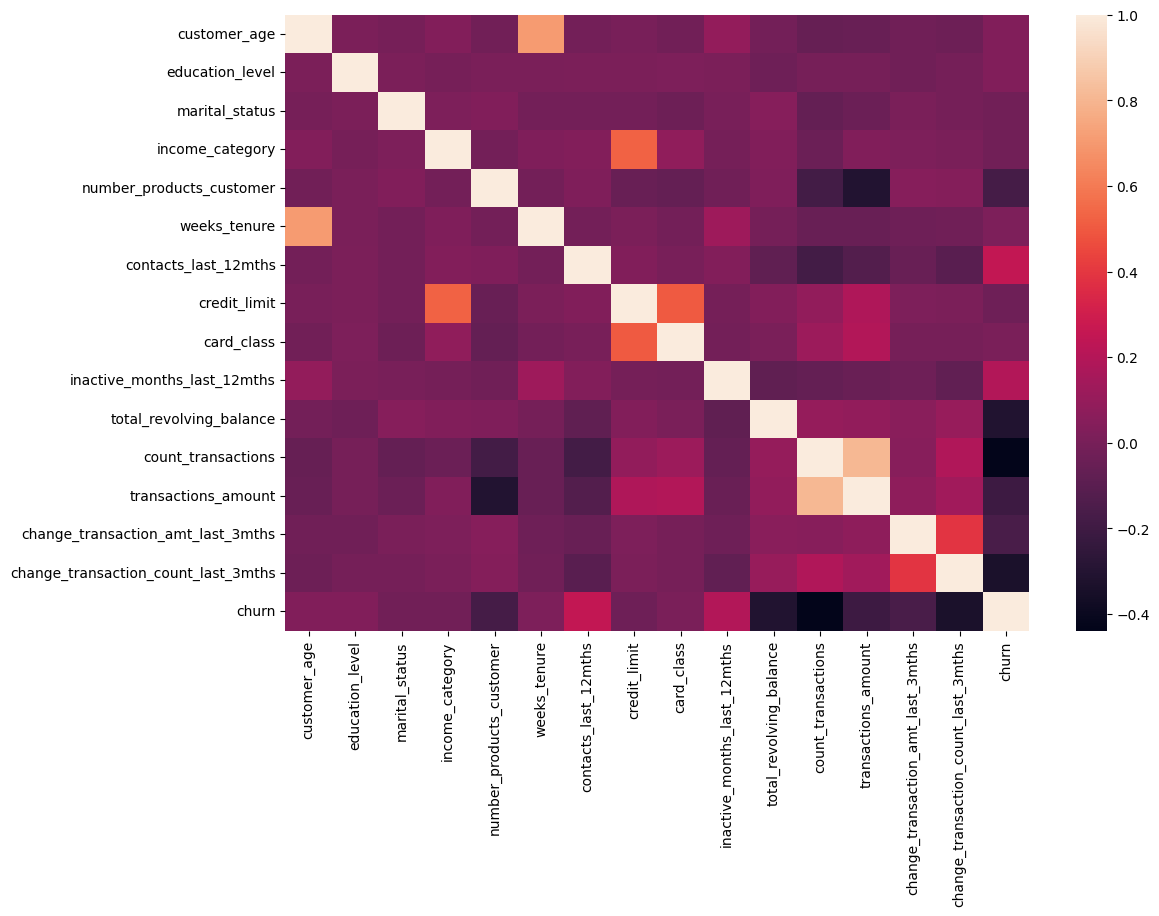

In [24]:
sns.heatmap(df.corr(),annot=False)
plt.show()

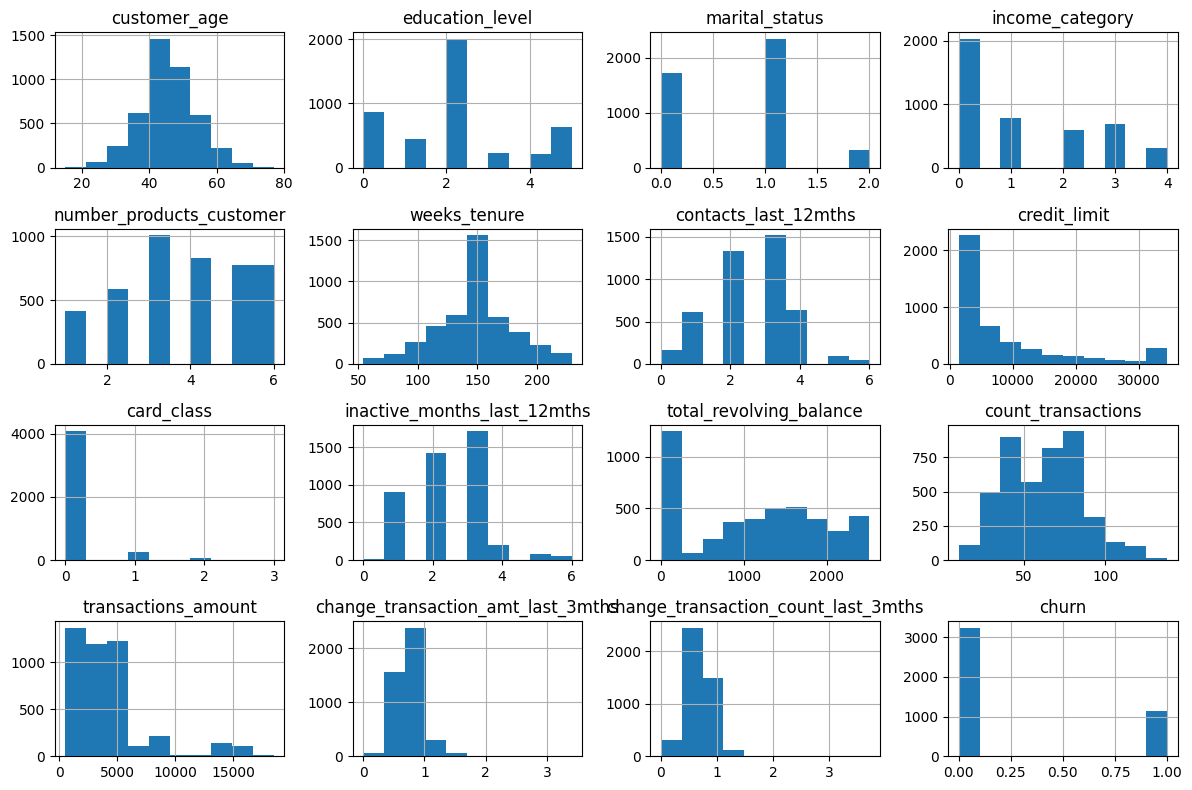

In [25]:
df.hist()
plt.tight_layout()

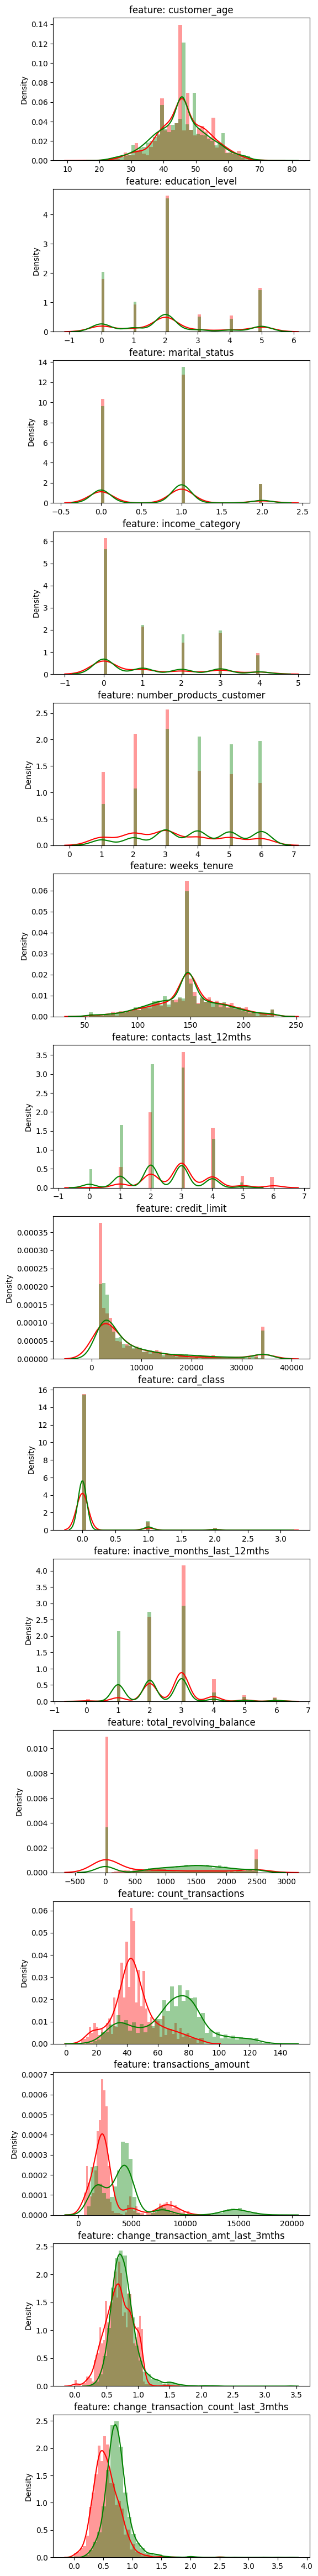

In [26]:
import seaborn as sns
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(28, 1)
plt.figure(figsize=(6,28*4))
for i, col in enumerate(df[df.iloc[:,0:15].columns]):
    ax5 = plt.subplot(gs[i])
    sns.distplot(df[col][df.churn == 1], bins=50, color='r')
    sns.distplot(df[col][df.churn == 0], bins=50, color='g')
    ax5.set_xlabel('')
    ax5.set_title('feature: ' + str(col))
plt.show()

In [28]:
# Train test split 

# Variables x and target y

x = df.drop(["churn"], axis = 1)
y = df["churn"]


# Separando entre treinamento e teste

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [29]:
# Treinando o modelo

# XGB Classifier

xgb_cl = xgb.XGBClassifier(objective = "binary:logistic"
                        , n_estimators = 100
                        , seed = 42
#                        , scale_pos_weight = 10
                        , colsample_bytree = 0.3
                        , learning_rate = 0.2
                        , max_depth = 5
                        , subsample = 0.8
                        )





avaliacao = [(x_train, y_train), (x_test, y_test)]

xgb_cl.fit(x_train, y_train, eval_metric = ["auc"], eval_set = avaliacao, verbose = True)
resultados_mod = xgb_cl.evals_result()                                                       #Resultado mod - para plotar os graficos




[0]	validation_0-auc:0.95612	validation_1-auc:0.92664
[1]	validation_0-auc:0.97296	validation_1-auc:0.95043
[2]	validation_0-auc:0.97822	validation_1-auc:0.95189
[3]	validation_0-auc:0.97951	validation_1-auc:0.94752
[4]	validation_0-auc:0.98199	validation_1-auc:0.95300
[5]	validation_0-auc:0.98258	validation_1-auc:0.95543
[6]	validation_0-auc:0.98268	validation_1-auc:0.95827
[7]	validation_0-auc:0.98705	validation_1-auc:0.96963
[8]	validation_0-auc:0.98781	validation_1-auc:0.97335
[9]	validation_0-auc:0.98869	validation_1-auc:0.97415
[10]	validation_0-auc:0.98909	validation_1-auc:0.97303
[11]	validation_0-auc:0.99238	validation_1-auc:0.97833
[12]	validation_0-auc:0.99373	validation_1-auc:0.98056
[13]	validation_0-auc:0.99378	validation_1-auc:0.98071
[14]	validation_0-auc:0.99471	validation_1-auc:0.98130
[15]	validation_0-auc:0.99465	validation_1-auc:0.98086
[16]	validation_0-auc:0.99462	validation_1-auc:0.98058
[17]	validation_0-auc:0.99499	validation_1-auc:0.98091
[18]	validation_0-au

In [30]:
#Predictions 

y_pred_train1 = xgb_cl.predict(x_train)
y_pred_test1 = xgb_cl.predict(x_test)



In [31]:
#Validation 


y_pred_val = xgb_cl.predict(df2)

# Evaluate the model on the validation data

submit_sample = pd.DataFrame(df2, columns=["churn"])
submit_sample["churn"] = y_pred_val



submit_sample

,churn
0,0
1,0
2,0
3,0
4,0
...,...
1878,1
1879,0
1880,0
1881,0


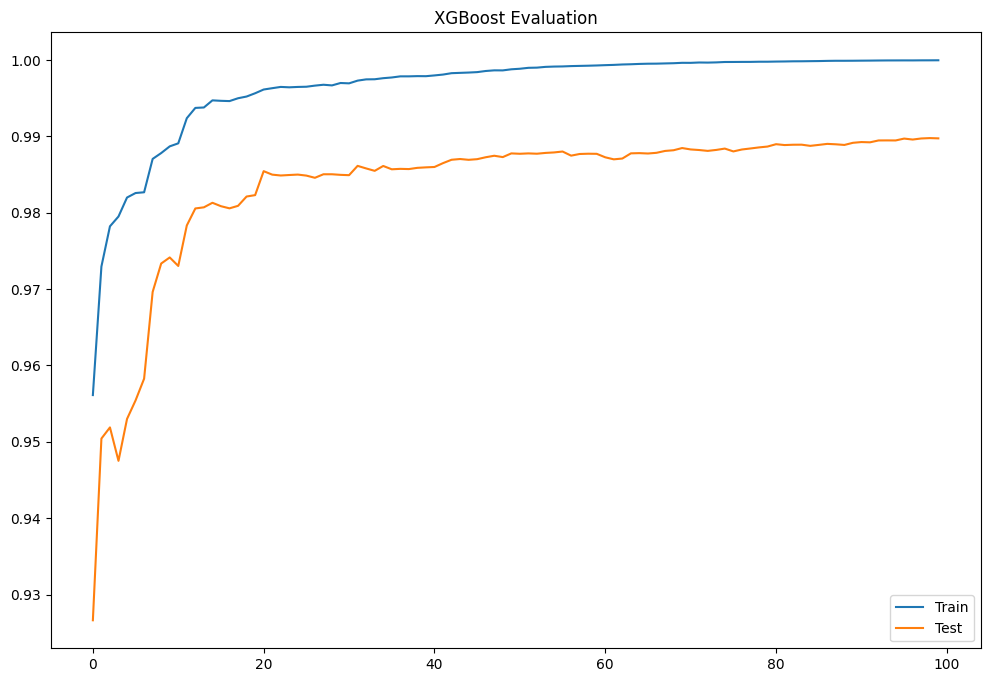

In [32]:
#Checking the evaluation chart, separation between train and test until reaching overfit

x = len(resultados_mod["validation_0"]["auc"])
x_axis = range(0, x)
fig, ax = pyplot.subplots()
ax.plot(x_axis, resultados_mod["validation_0"]["auc"], label = "Train")
ax.plot(x_axis, resultados_mod["validation_1"]["auc"], label = "Test")
plt.title("XGBoost Evaluation");
plt.legend(loc = "lower right");

In [33]:
print("Train")
print("Accuracy: {}%".format(round(accuracy_score(y_train, y_pred_train1)*100, 2)))
print("------------------------------")
print("Test")
print("Accuracy: {}%".format(round(accuracy_score(y_test, y_pred_test1)*100, 2)))

Train
Accuracy: 99.72%
------------------------------
Test
Accuracy: 95.68%


In [34]:
# Train - overfitted 
print("    TRAIN")
print(confusion_matrix(y_train, y_pred_train1))
print()
print("--------------------------------------------------------------------------------")
print()
print(classification_report(y_train, y_pred_train1))

    TRAIN
[[2579    5]
 [   5  924]]

--------------------------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2584
           1       0.99      0.99      0.99       929

    accuracy                           1.00      3513
   macro avg       1.00      1.00      1.00      3513
weighted avg       1.00      1.00      1.00      3513



In [35]:
# Test
print("   TEST")
print(confusion_matrix(y_test, y_pred_test1))
print()
print("--------------------------------------------------------------------------------")
print()
print(classification_report(y_test, y_pred_test1))

   TEST
[[647  17]
 [ 21 194]]

--------------------------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       664
           1       0.92      0.90      0.91       215

    accuracy                           0.96       879
   macro avg       0.94      0.94      0.94       879
weighted avg       0.96      0.96      0.96       879

